# Explore here

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from lazypredict.Supervised import LazyRegressor
import os
import sys
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error





In [6]:
print(sys.executable)

c:\Users\gamma\AppData\Local\Programs\Python\Python310\python.exe


In [7]:
datos = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv')

In [8]:
datos

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,30.97,3,no,northwest,10600.55
1334,18,female,31.92,0,no,northeast,2205.98
1335,18,female,36.85,0,no,southeast,1629.83
1336,21,female,25.80,0,no,southwest,2007.94


In [9]:
datos.charges.max()

63770.42801

In [10]:
datos.describe()

,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43


In [11]:
datos.duplicated().sum()

1

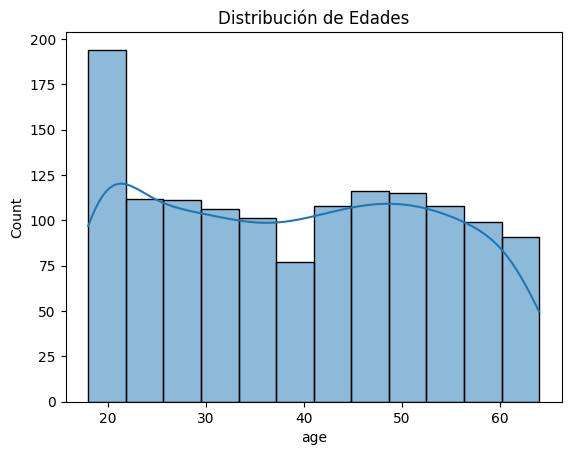

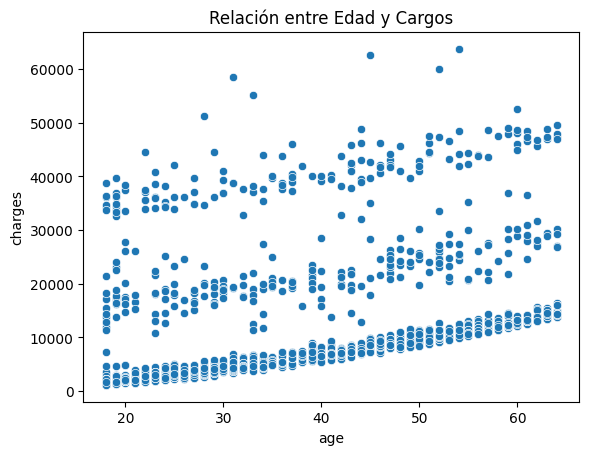

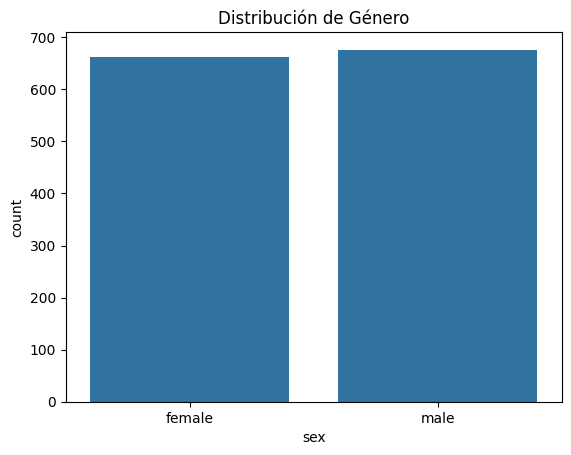

In [12]:
sns.histplot(data=datos, x='age', kde=True)
plt.title('Distribución de Edades')
plt.show()
sns.scatterplot(data=datos, x='age', y='charges')
plt.title('Relación entre Edad y Cargos')
plt.show()
sns.countplot(data=datos, x='sex')
plt.title('Distribución de Género')
plt.show()

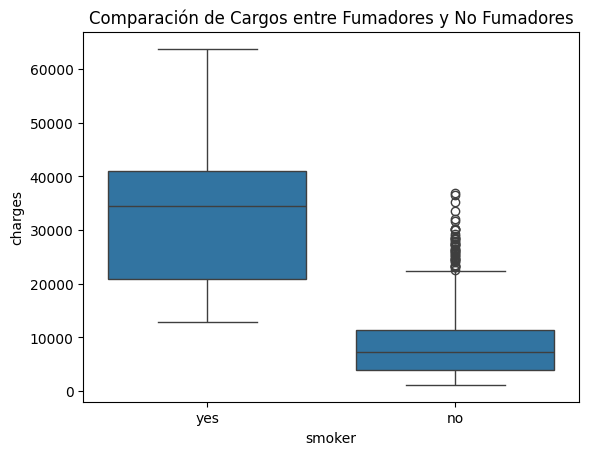

In [13]:
sns.boxplot(data=datos, x='smoker', y='charges')
plt.title('Comparación de Cargos entre Fumadores y No Fumadores')
plt.show()
# Agrupa los datos por la columna 'region' y calcula el promedio de 'charges' en cada región
region_charges_mean = datos.groupby('region')['charges'].mean()

(array([0, 1, 2, 3]),
 [Text(0, 0, 'northeast'),
  Text(1, 0, 'northwest'),
  Text(2, 0, 'southeast'),
  Text(3, 0, 'southwest')])

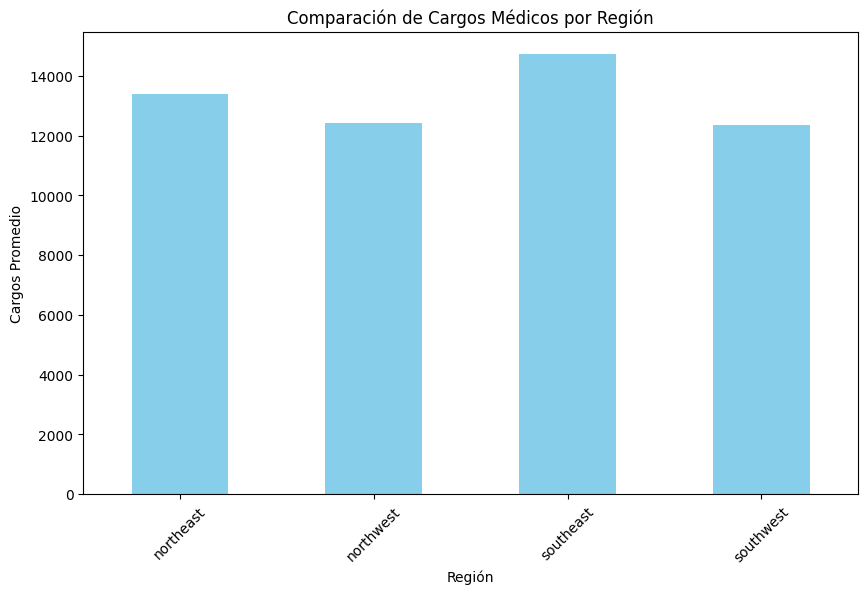

In [14]:
plt.figure(figsize=(10, 6))
region_charges_mean.plot(kind='bar', color='skyblue')
plt.title('Comparación de Cargos Médicos por Región')
plt.xlabel('Región')
plt.ylabel('Cargos Promedio')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mayor legibilidad

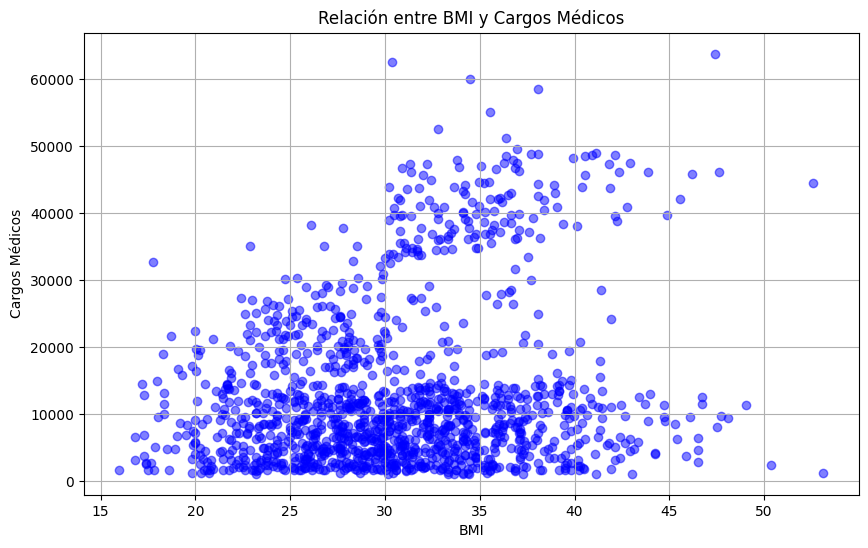

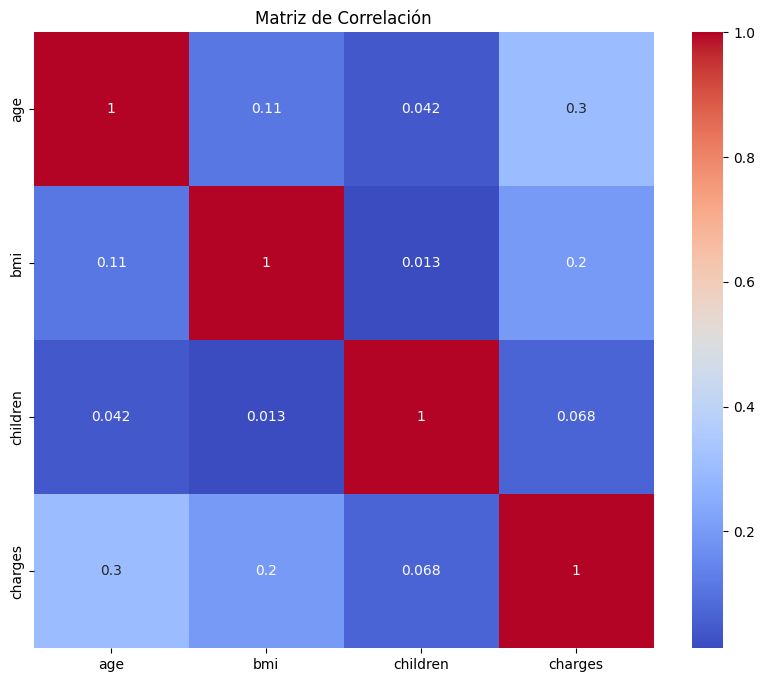

In [15]:
# Muestra el gráfico
plt.show()
# Crea un gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(datos['bmi'], datos['charges'], alpha=0.5, color='blue')
plt.title('Relación entre BMI y Cargos Médicos')
plt.xlabel('BMI')
plt.ylabel('Cargos Médicos')
plt.grid(True)
# Muestra el gráfico
plt.show()
numerical_columns1 = datos.select_dtypes(include=[np.number])
# Calcular la matriz de correlación
correlation_matrix = numerical_columns1.corr()
# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

In [16]:
datos_limpios = datos.drop_duplicates()
datos_limpios.duplicated().sum()

0

In [17]:
# La siguiente línea selecciona solo las columnas que son numéricas (es decir, int o float) 
# del DataFrame 'datos_limpios'. Esta selección se hace usando el método 'select_dtypes', 
# y especificamos que solo queremos las columnas de tipo numérico con 'include=[np.number]'.
columnas_numericas = datos_limpios.select_dtypes(include=[np.number])

# Luego, seleccionamos las columnas que no son numéricas, es decir, las columnas categóricas.
# Las columnas categóricas suelen ser de tipo 'object' (cadenas de texto) o 'category' (categorías).
# Nuevamente usamos 'select_dtypes' pero esta vez especificamos 'include=['object', 'category']'.
columnas_categoricas = datos_limpios.select_dtypes(include=['object', 'category'])

# Ahora, queremos convertir las columnas categóricas a un formato numérico.
# 'pd.get_dummies' es una función que hace esta conversión. Por ejemplo, si tienes una columna 
# llamada 'color' con valores 'rojo' y 'verde', esta función creará dos nuevas columnas: 
# 'color_rojo' y 'color_verde', donde cada fila tendrá un 1 o un 0 dependiendo del valor original.
# 'drop_first=True' es un argumento que le dice a la función que elimine la primera columna categórica 
# generada para evitar redundancia (porque si sabes que 'color_rojo' es 0, automáticamente sabes que 'color_verde' es 1).
categ_bin = pd.get_dummies(columnas_categoricas, drop_first=True)

# Ahora, renombramos las columnas 'smoker_yes' y 'sex_male'.
# El método 'rename' nos permite cambiar el nombre de las columnas. 
# En el argumento 'columns', proporcionamos un diccionario donde las claves son los nombres actuales y los valores son los nuevos nombres.
categ_bin = categ_bin.rename(columns={'smoker_yes': 'fumadores', 'sex_male': 'sexo'})

# Una vez que hemos procesado las columnas categóricas y numéricas por separado, 
# queremos combinarlas nuevamente en un solo DataFrame.
# 'pd.concat' es una función que une (concatena) varios DataFrames.
# Le pasamos una lista de los DataFrames que queremos unir (en este caso, 'columnas_numericas' y 'categ_bin').
# 'axis=1' especifica que queremos unir los DataFrames lado a lado, es decir, añadir columnas.
datos_limpios_nueva = pd.concat([columnas_numericas, categ_bin.astype(int)], axis=1)

# Finalmente, imprimimos el nuevo DataFrame para ver cómo quedó.
datos_limpios_nueva

,age,bmi,children,charges,sexo,fumadores,region_northwest,region_southeast,region_southwest
0,19,27.90,0,16884.92,0,1,0,0,1
1,18,33.77,1,1725.55,1,0,0,1,0
2,28,33.00,3,4449.46,1,0,0,1,0
3,33,22.70,0,21984.47,1,0,1,0,0
4,32,28.88,0,3866.86,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.97,3,10600.55,1,0,1,0,0
1334,18,31.92,0,2205.98,0,0,0,0,0
1335,18,36.85,0,1629.83,0,0,0,1,0
1336,21,25.80,0,2007.94,0,0,0,0,1


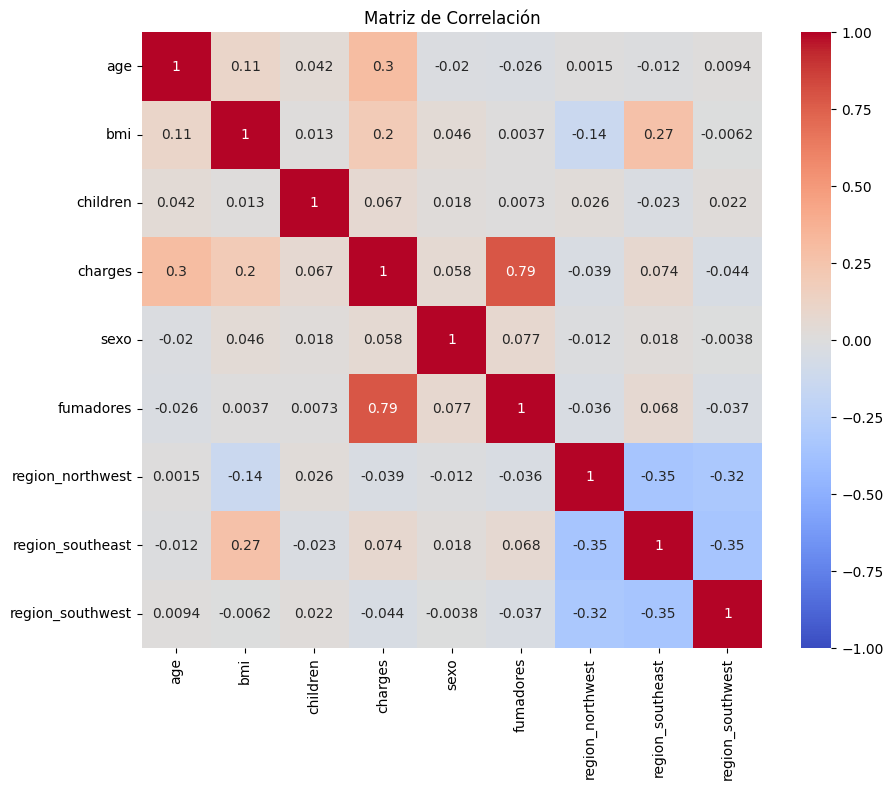

In [18]:
# Calcular la matriz de correlación
correlacion = datos_limpios_nueva.corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación')
plt.show()

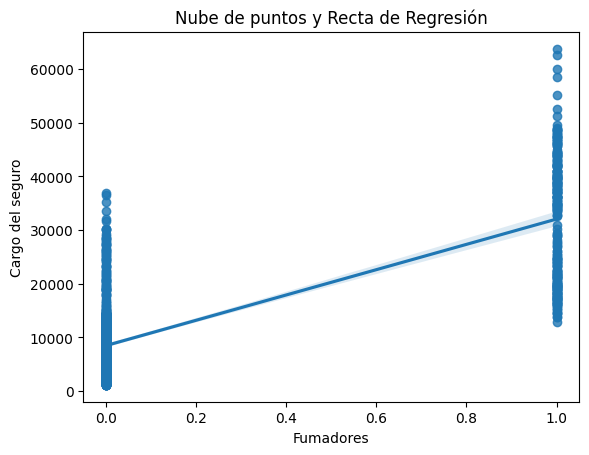

In [19]:
# Crear la nube de puntos y la recta de regresión
sns.regplot(x="fumadores", y="charges", data=datos_limpios_nueva)
plt.title("Nube de puntos y Recta de Regresión")
plt.xlabel("Fumadores")
plt.ylabel("Cargo del seguro")
plt.show()

In [20]:
datos_limpios_nueva.describe()

,age,bmi,children,charges,sexo,fumadores,region_northwest,region_southeast,region_southwest
count,1337.00,1337.00,1337.00,1337.00,1337.00,1337.00,1337.00,1337.00,1337.00
mean,39.22,30.66,1.10,13279.12,0.50,0.20,0.24,0.27,0.24
std,14.04,6.10,1.21,12110.36,0.50,0.40,0.43,0.45,0.43
min,18.00,15.96,0.00,1121.87,0.00,0.00,0.00,0.00,0.00
25%,27.00,26.29,0.00,4746.34,0.00,0.00,0.00,0.00,0.00
50%,39.00,30.40,1.00,9386.16,1.00,0.00,0.00,0.00,0.00
75%,51.00,34.70,2.00,16657.72,1.00,0.00,0.00,1.00,0.00
max,64.00,53.13,5.00,63770.43,1.00,1.00,1.00,1.00,1.00


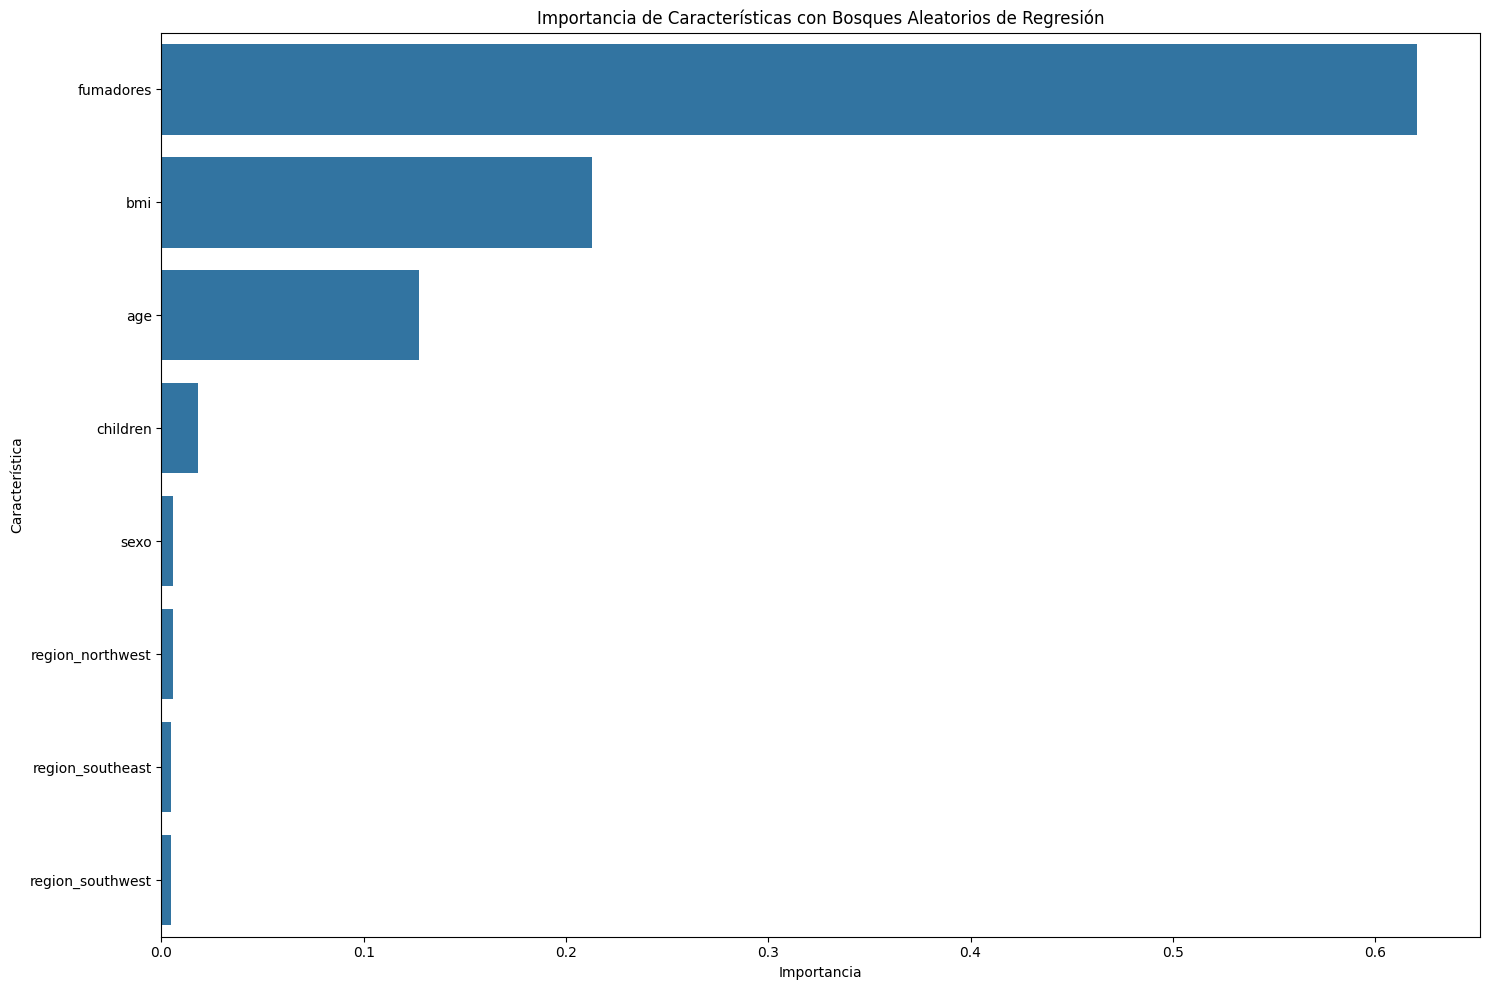

In [21]:
# Suponiendo que la columna 'charges' es tu variable objetivo
X = datos_limpios_nueva.drop('charges', axis=1)
y = datos_limpios_nueva['charges']

# Crear el modelo de Bosques Aleatorios de Regresión
clf = RandomForestRegressor(n_estimators=100)
clf.fit(X, y)

# Obtener importancia de características
importancias = clf.feature_importances_

# Crear un DataFrame para visualizar las importancias
df_importancia = pd.DataFrame({
    'Característica': X.columns,
    'Importancia': importancias
})

# Ordenar el DataFrame por importancia
df_importancia = df_importancia.sort_values(by='Importancia', ascending=False)

# Visualizar la importancia de características con un gráfico de barras
plt.figure(figsize=(15, 10))
sns.barplot(x='Importancia', y='Característica', data=df_importancia)
plt.title('Importancia de Características con Bosques Aleatorios de Regresión')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

In [22]:
#Limpiamos las columnas menos relevantes con charges, que es nuestra variable a predecir
datos_limpios_drop = datos_limpios_nueva[['charges','fumadores', 'age', 'bmi']]

datos_limpios_drop



,charges,fumadores,age,bmi
0,16884.92,1,19,27.90
1,1725.55,0,18,33.77
2,4449.46,0,28,33.00
3,21984.47,0,33,22.70
4,3866.86,0,32,28.88
...,...,...,...,...
1333,10600.55,0,50,30.97
1334,2205.98,0,18,31.92
1335,1629.83,0,18,36.85
1336,2007.94,0,21,25.80


In [23]:
X = datos_limpios_drop.drop('charges', axis=1)
y = datos_limpios_drop['charges']

# Instanciar el escalador
#escalador = MinMaxScaler()

# Aplicar el escalador a la columna 'charges'
#y_escalado = escalador.fit_transform(y.values.reshape(-1, 1))

# Ahora 'y_escalado' contiene los valores de 'charges' en el rango [0, 1]

In [24]:
# Imagina que X son factores como la edad, el peso, etc., y y es el costo del seguro.
# Queremos averiguar cómo estos factores afectan el costo del seguro.
# Primero, añadimos una constante a X para tener un punto de partida.
X = sm.add_constant(X)  # Esto es como añadir una línea base en un experimento.
# Ahora, creamos un modelo para entender cómo estos factores afectan el costo del seguro.
model = sm.OLS(y, X)  # Esto es como hacer un experimento para ver la relación.
# Luego, ajustamos el modelo a nuestros datos para obtener los resultados.
results = model.fit()  # Esto es como analizar los resultados del experimento.
# Ahora, podemos usar estos resultados para entender mejor cómo los factores afectan el costo del seguro

In [25]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     1314.
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        13:17:00   Log-Likelihood:                -13547.
No. Observations:                1337   AIC:                         2.710e+04
Df Residuals:                    1333   BIC:                         2.712e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.167e+04    938.136    -12.441      0.0

Dep. Variable: charges: Estamos tratando de predecir el costo ("charges") del seguro médico.

R-squared y Adj. R-squared (0.747): Es como un puntaje en un videojuego. Nos dice cuánto de las variaciones en el costo del seguro podemos explicar con nuestro modelo. Si es 1, es perfecto (como un 100% en un examen). Aquí, es 0.747, lo que significa que nuestro modelo puede explicar el 74.7% de las variaciones en el costo del seguro, ¡lo cual es bastante bueno!

F-statistic y Prob (F-statistic): Estos números nos dicen si nuestro modelo es mejor que no tener modelo en absoluto. Si el "Prob (F-statistic)" es muy pequeño (cercano a 0), eso es bueno y significa que nuestro modelo es útil.

coef: Estos son los valores que nos dicen cuánto cambia el costo del seguro por cada cambio en nuestros factores. Por ejemplo, el coeficiente para "age" es 259.4312, lo que significa que por cada año que una persona es más vieja, el costo del seguro aumenta en aproximadamente $259.43.

std err: Es una medida de cuán confiados estamos en nuestros coeficientes. Cuanto menor sea este número, más confiados estamos.

t y P>|t|: Estos números nos ayudan a saber si un factor es relevante para predecir el costo. Si "P>|t|" es muy pequeño (cercano a 0), significa que ese factor es importante.

[0.025 0.975]: Estos son intervalos que nos dicen dónde esperamos que se encuentren los coeficientes reales la mayoría de las veces.

Omnibus, Skew, Kurtosis, etc.: Estas son estadísticas adicionales que nos dan más información sobre cómo se comportan nuestros datos y las predicciones del modelo. Por ahora, no te preocupes demasiado por ellos.

En resumen, este modelo nos dice que si fumas, tu seguro médico será más caro. Además, cuanto más viejo seas y mayor sea tu índice de masa corporal (bmi), también esperamos que el costo del seguro sea más alto. ¡Y nuestro modelo puede explicar alrededor del 74.7% de estas variaciones en el costo del seguro!

1-Residuos

Omnibus: Imagina que estás tratando de adivinar el peso de las manzanas en una caja. Después de adivinar, comparas tus adivinanzas con los pesos reales. Las diferencias entre tus adivinanzas y los pesos reales se llaman residuos. Ahora, si tus adivinanzas son buenas, estos residuos se parecerán a una cuando los dibujes en papel. El Omnibus te dice qué tan parecido a una campana es ese dibujo. Cuanto más bajo sea el número, mejor.

Prob(Omnibus): Este es como un juego de "caliente o frío" con el Omnibus. Si este número es muy cercano a 1, significa que estás "caliente" (¡bien hecho!). Pero si es cercano a 0, como en este caso, estás "frío" (¡oh, no!).

Durbin-Watson: Imagina que después de adivinar el peso de una manzana, tu siguiente adivinanza se ve afectada por tu adivinanza anterior. Eso sería extraño, ¿verdad? Bueno, Durbin-Watson verifica precisamente eso. Si el número es cerca de 2, significa que una adivinanza no afecta la siguiente. En este caso, el número es 2.077, ¡así que estás haciendo bien!

Jarque-Bera (JB) y Prob(JB): Estos son como el Omnibus y Prob(Omnibus), pero son una forma diferente de mirar el dibujo de la campana. El JB te dice qué tan bueno es el dibujo y el Prob(JB) te dice si estás "caliente" o "frío".

Skew (Asimetría): Si cortas una manzana por la mitad, ¿las dos mitades se ven iguales? Si es así, no hay inclinación. Pero si una mitad es más grande, hay una inclinación. En este caso, la asimetría es 1.212, lo que significa que hay una pequeña inclinación en cómo se ven los residuos.

Kurtosis: Imagina que estás mirando una montaña desde lejos. ¿La montaña es puntiaguda en la cima o es más bien plana? La Kurtosis te dice eso sobre el dibujo de la campana de tus residuos. En este caso, es 5.613, lo que significa que es un poco más puntiagudo de lo normal.

Cond. No. (Número de Condición): Este número te dice si algunas de tus adivinanzas están muy relacionadas entre sí, lo que puede complicar las cosas. Un número muy grande aquí, como 3.32e+16, significa que hay que tener cuidado porque algunas adivinanzas podrían estar afectando a otras.

In [26]:
# Accedemos a los residuos del modelo
residuos = results.resid

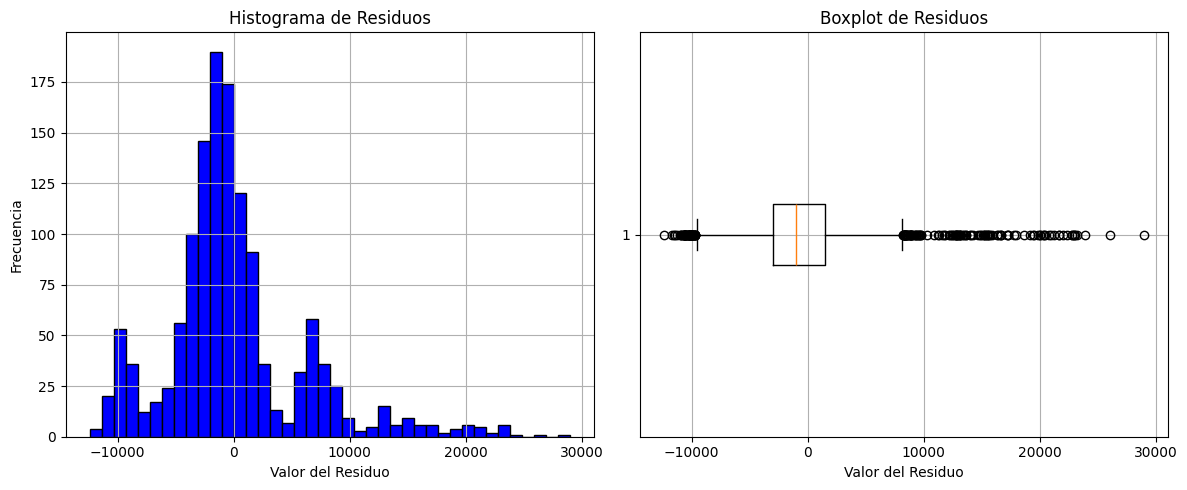

In [27]:
# Crea una figura con dos subgráficos (uno para el histograma y otro para el boxplot)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histograma de los residuos en el primer subgráfico (ax1)
ax1.hist(residuos, bins=40, color='blue', edgecolor='black')
ax1.set_title('Histograma de Residuos')
ax1.set_xlabel('Valor del Residuo')
ax1.set_ylabel('Frecuencia')
ax1.grid(True)

# Boxplot de los residuos en el segundo subgráfico (ax2)
ax2.boxplot(residuos, vert=False)
ax2.set_title('Boxplot de Residuos')
ax2.set_xlabel('Valor del Residuo')
ax2.grid(True)

# Muestra la figura con ambos gráficos
plt.tight_layout()  # Ajusta los márgenes para evitar superposiciones
plt.show()

In [28]:
# Aquí estamos viendo cuánto se equivocó en promedio nuestro modelo.
# Los "residuos" son la diferencia entre lo que el modelo predijo y lo que realmente sucedió.
# Si el "Valor medio de los residuos" es 0, nuestro modelo es como un arquero que a veces falla a la izquierda y a veces a la derecha, pero en promedio da en el centro.
# Si es diferente de 0, es como un arquero que siempre falla hacia un lado.
print(f'Valor medio de los residuos: {residuos.mean()}')

Valor medio de los residuos: -1.807860508017805e-10


In [29]:
# Usamos el cubo mágico de Shapiro para ver qué tan parecidos a una campana son nuestros residuos.
# El cubo nos da dos cosas:
# 1. Un número que ahora no nos importa (lo llamamos "_").
# 2. p_value: Un juego de "caliente o frío". Si es cercano a 1, nuestras diferencias son como una campana.
# Si es cercano a 0, no se parecen mucho a una campana.
_, p_value = stats.shapiro(residuos)

# Aquí simplemente vemos el valor de "p_value" para saber si estamos "calientes" o "fríos".
p_value

2.8383262555135642e-28

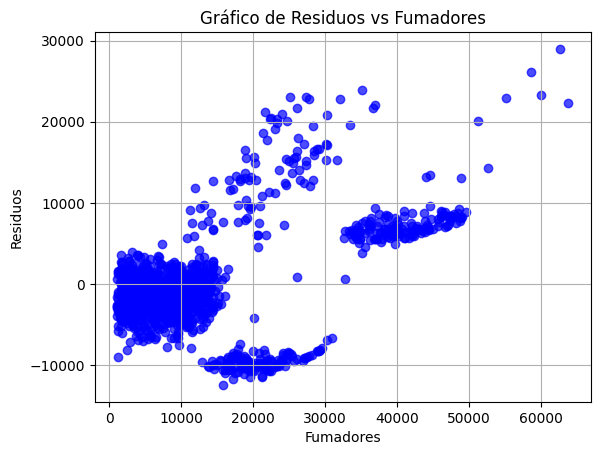

In [30]:
# Crea el gráfico de residuos versus valores ajustados
plt.scatter(y, residuos, c='blue', alpha=0.7)
plt.title('Gráfico de Residuos vs Fumadores')
plt.xlabel('Fumadores')
plt.ylabel('Residuos')
plt.grid(True)
plt.show()

Piensa en este gráfico como un campo de juego con pelotas.

Valores ajustados (eje horizontal): Es la distancia a la que intentabas lanzar una pelota.

Residuos (eje vertical): Es cuánto te pasaste o te quedaste corto al lanzarla. Si el residuo es positivo, lanzaste la pelota más lejos de lo que querías. Si es negativo, no la lanzaste lo suficientemente lejos.

Puntos azules: Cada punto representa una vez que lanzaste la pelota.

Entonces, ¿qué nos dice el gráfico?

Zona cerca del 0: Aquí, la mayoría de las veces lanzaste la pelota justo donde querías. ¡Bien hecho!

A medida que te alejas del 0: Las cosas se complican. A veces lanzas la pelota mucho más lejos o mucho más cerca de lo que pretendías. Estos son los puntos que están más dispersos.

Los puntos dispersos a la derecha: Indican que cuando intentas lanzar muy lejos, la pelota no siempre va donde quieres. A veces se va mucho más lejos y otras no lo suficiente.

En resumen, este gráfico te muestra cómo te va lanzando pelotas a diferentes distancias. Es como un registro de tu precisión. Y parece que cuando intentas lanzar muy lejos, ¡es más difícil acertar! 

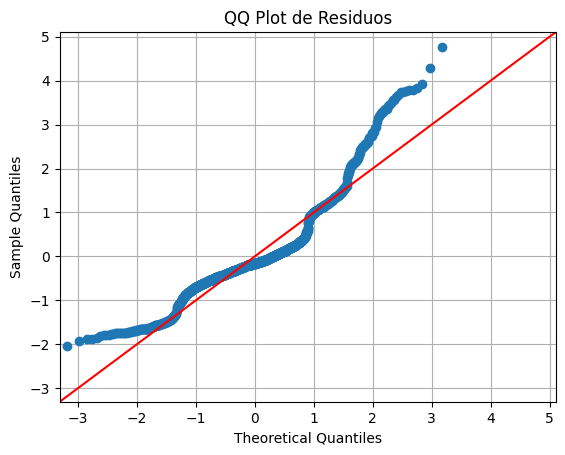

In [31]:
# Crea un QQ plot de los residuos
fig = sm.qqplot(residuos, line='45', fit=True)
plt.title('QQ Plot de Residuos')
plt.grid(True)
plt.show()

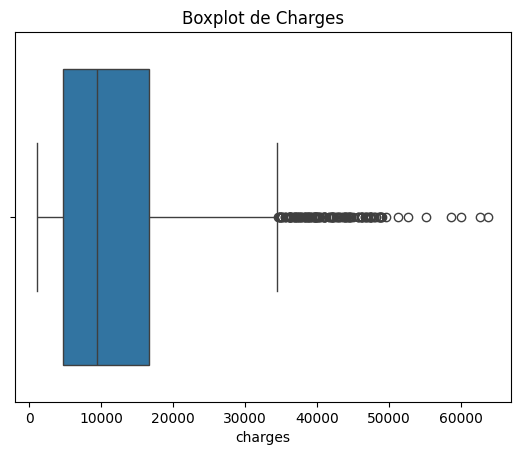

In [32]:
sns.boxplot(x=datos_limpios_drop['charges'])
plt.title('Boxplot de Charges')
plt.show()

Antes de decidir eliminar los valores atípicos, es esencial considerar el contexto y la naturaleza de los datos. En el contexto de los costos médicos, esos valores atípicos podrían representar casos donde los individuos incurrieron en costos médicos extremadamente altos, lo cual es plausible. Si esos valores atípicos representan datos válidos y no errores, eliminarlos podría llevar a conclusiones erróneas. Si decides que necesitas eliminarlos, puedes hacerlo usando el método que discutimos anteriormente con el IQR. Sin embargo, es crucial justificar y documentar cualquier decisión de este tipo.

In [33]:
# Paso 1: Calculamos la media y la desviación estándar
mean_charges = datos_limpios_drop['charges'].mean()
std_charges = datos_limpios_drop['charges'].std()

# Paso 2: Definimos los límites
lower_limit = mean_charges - 2*std_charges
upper_limit = mean_charges + 2*std_charges

# Paso 3: Filtramos para obtener solo los outliers
outliers = datos_limpios_drop[(datos_limpios_drop['charges'] < lower_limit) | (datos_limpios_drop['charges'] > upper_limit)]

outliers

,charges,fumadores,age,bmi
14,39611.76,1,27,42.13
23,37701.88,1,34,31.92
29,38711.00,1,31,36.30
34,51194.56,1,28,36.40
38,39774.28,1,35,36.67
...,...,...,...,...
1288,38344.57,1,20,39.40
1300,62592.87,1,45,30.36
1301,46718.16,1,62,30.88
1303,37829.72,1,43,27.80


In [34]:
# Paso 1: Calcula Q1 y Q3
Q1 = datos_limpios_drop['charges'].quantile(0.25)
Q3 = datos_limpios_drop['charges'].quantile(0.75)

# Paso 2: Calcula IQR
IQR = Q3 - Q1

# Paso 3: Define los límites
lower_limit_IQR = Q1 - 1.5*IQR
upper_limit_IQR = Q3 + 1.5*IQR

# Paso 4: Filtra para obtener solo los outliers
outliers_IQR = datos_limpios_drop[(datos_limpios_drop['charges'] < lower_limit_IQR) | (datos_limpios_drop['charges'] > upper_limit_IQR)]

outliers_IQR

,charges,fumadores,age,bmi
14,39611.76,1,27,42.13
19,36837.47,1,30,35.30
23,37701.88,1,34,31.92
29,38711.00,1,31,36.30
30,35585.58,1,22,35.60
...,...,...,...,...
1300,62592.87,1,45,30.36
1301,46718.16,1,62,30.88
1303,37829.72,1,43,27.80
1313,36397.58,1,19,34.70


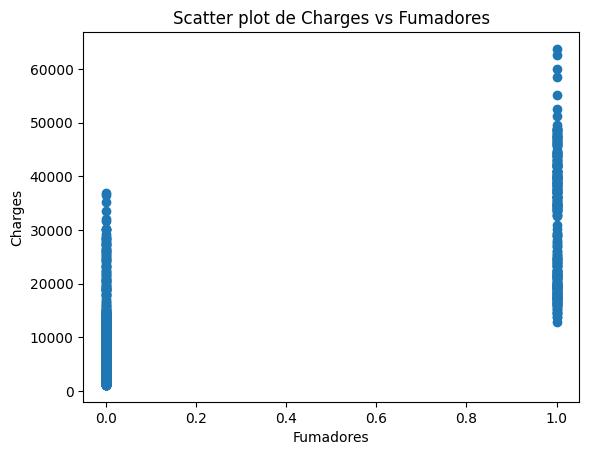

In [35]:
# Por ejemplo, contra 'fumadores'
plt.scatter(datos_limpios_drop['fumadores'], datos_limpios_drop['charges'])
plt.title('Scatter plot de Charges vs Fumadores')
plt.xlabel('Fumadores')
plt.ylabel('Charges')
plt.show()

Los outliers en el grupo de fumadores podrían ser indicativos de casos extremos reales donde las personas han incurrido en cargos médicos muy altos debido a problemas de salud relacionados con el tabaquismo. Eliminar estos puntos podría distorsionar la relación real entre fumar y los cargos médicos.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

reg = LazyRegressor()

models, predictions = reg.fit(X_train, X_test, y_train, y_test)

models

100%|██████████| 42/42 [00:02<00:00, 20.55it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 3
[LightGBM] [Info] Start training from score 13030.203373


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.90,0.90,4244.54,0.09
HistGradientBoostingRegressor,0.89,0.89,4414.33,0.20
LGBMRegressor,0.89,0.89,4483.61,0.04
KNeighborsRegressor,0.88,0.88,4747.65,0.01
RandomForestRegressor,0.87,0.88,4785.26,0.28
BaggingRegressor,0.87,0.87,4861.01,0.05
AdaBoostRegressor,0.86,0.87,4947.60,0.03
XGBRegressor,0.85,0.85,5281.62,0.10
ExtraTreesRegressor,0.84,0.84,5446.96,0.19


Lazy Predict es una biblioteca de Python que facilita la construcción y comparación de modelos básicos de aprendizaje automático para identificar rápidamente los más adecuados para un conjunto de datos específico. Esta biblioteca ofrece dos herramientas principales: LazyClassifier y LazyRegressor.

LazyClassifier: Se utiliza para problemas de clasificación. Permite aplicar y comparar rápidamente varios modelos de clasificación en un conjunto de datos. Por ejemplo, en el caso de un conjunto de datos de cáncer de mama, LazyClassifier puede evaluar rápidamente varios modelos para predecir si una persona sufre de cáncer o no.

LazyRegressor: Se utiliza para problemas de regresión. Similar al LazyClassifier, permite aplicar y comparar varios modelos de regresión en un conjunto de datos. Un ejemplo de su uso es en el conjunto de datos de precios de viviendas de Boston, donde se puede evaluar rápidamente diferentes modelos para predecir el precio de las viviendas.

Ambas herramientas son útiles para obtener una visión rápida de qué modelos podrían funcionar mejor para un conjunto de datos dado, sin necesidad de ajustar parámetros o realizar una configuración detallada. Esto es especialmente útil en las etapas iniciales de un proyecto de aprendizaje automático, donde se desea explorar rápidamente diferentes opciones de modelos.

In [37]:
escalador = MinMaxScaler()

In [38]:
# Aquí estamos diciendo: "Quiero un modelo especial llamado 'GradientBoostingRegressor'. 
# Pero quiero que siempre actúe de la misma manera cada vez que lo use, 
# así que le doy un número especial llamado 'random_state' igual a 42".
modelo_entrenado = GradientBoostingRegressor(random_state=42)

# Aquí le decimos al modelo: "Toma estos datos de entrenamiento (X_train) y estas respuestas (y_train), 
# y aprende de ellos. Así, en el futuro, cuando te dé nuevos datos, podrás adivinar la respuesta".
modelo_entrenado.fit(X_train,y_train)

# Una vez que el modelo ha aprendido, le decimos: "Aquí tienes algunos datos (X_test) que no has visto antes.
# Usa lo que aprendiste y dime cuál crees que es la respuesta para estos datos".
prediccion_y = modelo_entrenado.predict(X_test)

# Finalmente, queremos saber qué tan bueno fue nuestro modelo al adivinar las respuestas. 
# Entonces comparamos las respuestas reales (y_test) con las que nuestro modelo adivinó (prediccion_y).
# El "mean_absolute_error" nos dice, en promedio, cuánto se equivocó nuestro modelo en sus adivinanzas.
mse = mean_absolute_error(y_test, prediccion_y)

# Esta línea simplemente muestra el error promedio que cometió nuestro modelo.
mse

2394.385318540932

In [39]:
# Realizamos la validación cruzada. En este caso, vamos a hacer una validación cruzada de 5 pliegues (folds).
# Esto significa que tus datos se dividirán en 5 partes; el modelo se entrenará con 4 de ellas y se probará con la 1 restante.
# Esto se repetirá 5 veces, probando cada vez con una parte diferente.
puntuaciones = cross_val_score(modelo_entrenado, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# Las puntuaciones que obtenemos están en formato negativo porque es una convención de sklearn 
# (los valores más altos son mejores). Pero en realidad queremos el valor positivo del error.
puntuaciones_positivas = -puntuaciones

# Ahora, podemos ver el error medio de validación cruzada y su desviación estándar.
error_medio = puntuaciones_positivas.mean()
desviacion_estandar = puntuaciones_positivas.std()

print(f"Error medio de validación cruzada: {error_medio:.2f}")
print(f"Desviación estándar: {desviacion_estandar:.2f}")

Error medio de validación cruzada: 2742.26
Desviación estándar: 180.47


Error medio de validación cruzada (2742.26): Este valor representa el error promedio al predecir y_train en una validación cruzada de 5 pliegues. Si este valor es bajo en relación al rango de tus datos objetivo (y_train), indica que tu modelo tiene un buen rendimiento en términos de error absoluto. Si, por ejemplo, los valores de y_train varían entre 0 y 100.000, un error medio de 2742.26 podría considerarse relativamente bajo. Sin embargo, si varían entre 0 y 5000, entonces 2742.26 es un error considerable.

Desviación estándar (180.47): Este valor te indica cuánto varían las puntuaciones de validación cruzada entre los diferentes pliegues. Una desviación estándar más pequeña indica que el modelo es más estable y tiene un rendimiento similar en diferentes subconjuntos de tus datos. Una desviación estándar más grande indica una mayor variabilidad en el rendimiento del modelo, lo que podría ser una señal de advertencia de que el modelo podría no ser muy confiable o que los datos podrían tener algunas irregularidades.

In [40]:
# Datos de entrenamiento (ejemplo hipotético)
X = datos[['smoker', 'age', 'bmi']]
y = datos['charges']

# Crear un modelo y entrenarlo
modelo_nuevo = GradientBoostingRegressor(random_state=42)
modelo_nuevo.fit(X, y)

# Datos de entrada para hacer una predicción
edad = 27
fumador = 1  # 1 para fumador
bmi = 42.13

# Agrupando los datos de entrada en una lista
datos_entrada = [[fumador, edad, bmi]]

# Realiza la predicción con el modelo reentrenado
prediccion_charges = modelo_nuevo.predict(datos_entrada)

# Imprime la predicción
print("La predicción de charges es:", prediccion_charges[0])


ValueError: could not convert string to float: 'yes'